# Documentation on network analysis
The goal of doing a character network analysis is to analyze the number of interactions that the characters have inside the story, do a comparison between interactions in the story, screenplay 1996 and the transcription of the screenplay (1999). 
For each of the XML documents analyzed we have created the following: a csv file containing the interactions; a static graph; an interactive graph.  

The first thing that was done was to search manually for all the direct and indirect dialogues inside the texts and then tag them inside the **XML-TEI**. The tagging in the book was done using ```<said>``` , and adding for each dialogue the attribute "who" that underlines who is speaking and "toWhom" addresses the listener. As for the screenplay, we added manually the tag ```<sp>``` which is used to identify individual speeches in performance texts, followed by the attributes "who" and "toWhom". Multiple speakers or listeners are added as a single string and separated with a comma. 

The libraries needed to extract information from the TEI document, visualize it in a static graph and then in a dynamic one are: [xml.etree](https://docs.python.org/3/library/xml.etree.elementtree.html#), [NetworkX](https://networkx.org/), [Bokeh](https://docs.bokeh.org/en/latest/).


**xml.etree** is used to progressively search into the hierarchical structure of the XML-TEI document. In this case we need to search inside the TEI header the content inside the tag ```<said>``` or ```<sp>``` and get all the information contained in the tags "who" and "toWhom". This process is done for each ```<said>``` or ```<sp>``` tag and then the information is added as a tuple in a `content_list`. The script founds if speakers or listeners are more than one (so separated by a comma), splits them, adds into a list (`listener_tags` or `who_tags`) and appends them into `content_list`. `interactions` is a dictionary that is used to store the number of times the characters interact with each other, counting the number of times the tuple is inside `content_list`. 

Then, we store the data into an external csv file. 




In [64]:
from xml.etree import ElementTree as ET
import csv

def generate_network_csv(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    content_list = []
    for said_tag in root.findall('.//{http://www.tei-c.org/ns/1.0}said'):
        who_tag = said_tag.get('who')
        listener_tag = said_tag.get('toWhom')
        if who_tag is not None:
            content_list.append((who_tag,listener_tag))

    interactions={}
    for i in content_list:
        if i not in interactions:
            interactions[i] = 1
        else:
            interactions[i] +=1
    
        # Write interactions to a CSV file
    with open('interactions_book.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        
        # Write header
        csvwriter.writerow(['Character', 'Listener', 'Interaction Count'])
        
        # Write data rows
        for (who, listener), count in interactions.items():
            listener_str = listener if listener else "unknown"
            csvwriter.writerow([who, listener_str, count])

    print("CSV file 'interactions_book.csv' created.")

generate_network_csv("..//../Arthur Schnitzler - Dream Story (2003, Green Integer).xml")

CSV file 'interactions_book.csv' created.


In [65]:
from xml.etree import ElementTree as ET
import csv

def generate_network_csv(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    content_list = []
    for said_tag in root.findall('.//{http://www.tei-c.org/ns/1.0}sp'):
        who_tag = said_tag.get('who')
        listener_tag = said_tag.get('toWhom')
        if listener_tag is not None and who_tag is not None:
            if "," in listener_tag:
                listener_tags = listener_tag.split(', ')
                for i in listener_tags:
                    content_list.append((who_tag, i))
            elif ',' in who_tag:
                who_tags = who_tag.split(',')
                for i in who_tags:
                    content_list.append((i, listener_tag))
            else:
                content_list.append((who_tag, listener_tag))

    interactions={}
    for i in content_list:
        if i not in interactions:
            interactions[i] = 1
        else:
            interactions[i] +=1
    
        # Write interactions to a CSV file
    with open('interactions_screenplay99.csv', 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        
        # Write header
        csvwriter.writerow(['Character', 'Listener', 'Interaction Count'])
        
        # Write data rows
        for (who, listener), count in interactions.items():
            listener_str = listener if listener else "unknown"
            csvwriter.writerow([who, listener_str, count])

    print("CSV file 'interactions_screenplay99.csv' created.")


generate_network_csv("..//../eyes-wide-shut-1999-transcription.xml")

CSV file 'interactions_screenplay99.csv' created.


**NetworkX** is used visualize the data extracted from the XML-TEI in a static network graph. The data previously created is stored in CSV files is now used to create a dataframe using pandas. Then data inside the columns "Character" and "Listener" are transformed into nodes and their relationship through edges by the library. Labels are added to visualize clearly the relationships between speaker and listener. 
Values are then sorted in a descending order, highlighting the characters that have more interactions inside the text, then a bar graph has been created to visualize the 10 characters that have interacted the most throughout the narration.

In [66]:
import networkx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [67]:


ds_df = pd.read_csv('interactions_book.csv')

print(ds_df)

          Character       Listener  Interaction Count
0          Fridolin       daughter                  2
1          Fridolin      Albertina                 42
2         Albertina       Fridolin                 29
3          Fridolin       Marianne                 16
4          Marianne       Fridolin                  8
5          Fridolin        unknown                 24
6             Mizzi       Fridolin                 14
7          Fridolin          Mizzi                  5
8             Mizzi        unknown                  1
9          Fridolin     Nachtigall                 39
10       Nachtigall       Fridolin                 44
11          Gibiser       Fridolin                 16
12         Fridolin        Gibiser                 17
13          Gibiser      Gentlemen                  4
14        Gentlemen        Gibiser                  3
15        Pierrette        Gibiser                  2
16          Gibiser      Pierrette                  3
17         Fridolin       Fr

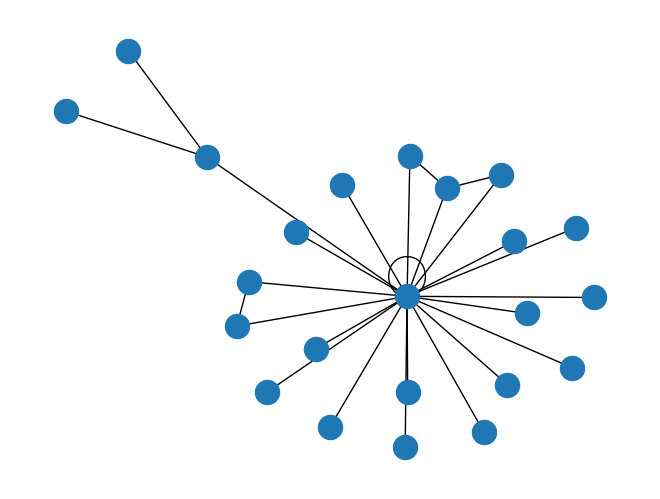

In [68]:
G = networkx.from_pandas_edgelist(ds_df, 'Character', 'Listener', 'Interaction Count')
networkx.write_graphml(G, 'DS-network.graphml')
networkx.draw(G)

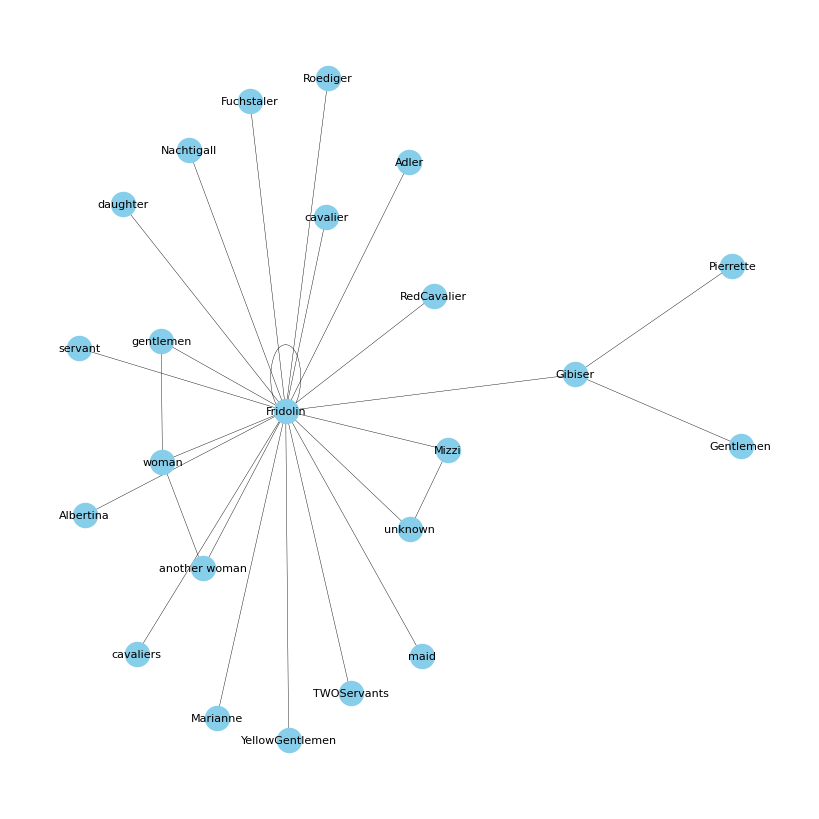

In [69]:
plt.figure(figsize=(8,8))
networkx.draw(G, with_labels=True, node_color='skyblue', width=.3, font_size=8)

In [70]:
networkx.degree(G)

DegreeView({'Fridolin': 22, 'daughter': 1, 'Albertina': 1, 'Marianne': 1, 'unknown': 2, 'Mizzi': 2, 'Nachtigall': 1, 'Gibiser': 3, 'Gentlemen': 1, 'Pierrette': 1, 'TWOServants': 1, 'woman': 3, 'another woman': 2, 'cavalier': 1, 'cavaliers': 1, 'YellowGentlemen': 1, 'gentlemen': 2, 'RedCavalier': 1, 'servant': 1, 'maid': 1, 'Fuchstaler': 1, 'Roediger': 1, 'Adler': 1})

In [71]:
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)

In [72]:
degree_df = pd.DataFrame(G.nodes(data='degree'), columns=['node', 'degree'])
degree_df = degree_df.sort_values(by='degree', ascending=False)
degree_df

,node,degree
0,Fridolin,22
7,Gibiser,3
11,woman,3
5,Mizzi,2
16,gentlemen,2
12,another woman,2
4,unknown,2
3,Marianne,1
15,YellowGentlemen,1
21,Roediger,1


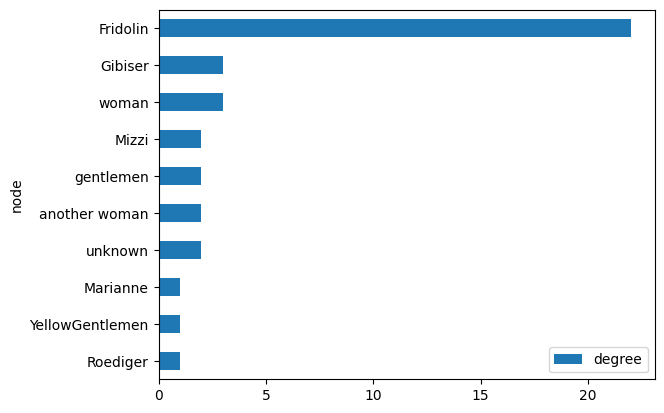

In [73]:
num_nodes_to_inspect = 10
degree_df[:num_nodes_to_inspect].plot(x='node', y='degree', kind='barh').invert_yaxis()

In [74]:
from bokeh.io import output_notebook, show, save
output_notebook()

Loading BokehJS ...

In [75]:

# Read the csv files
df_ds = pd.read_csv('interactions_screenplay96.csv')



In [76]:
G = networkx.from_pandas_edgelist(df_ds, 'Character', 'Listener', 'Interaction Count')

In [77]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

In [78]:
#Choose a title!
title = 'Screenplay 1996 Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Character", "@index")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")

In [79]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap

In [80]:
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)

In [81]:
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in networkx.degree(G)])
networkx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

In [82]:
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'Screenplay 1999 Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Character", "@index"),
        ("Interactions", "@degree")
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html\
network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")

In [83]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
from networkx.algorithms import community

In [84]:
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)

In [85]:
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in networkx.degree(G)])
networkx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

In [86]:
communities = community.greedy_modularity_communities(G)

In [87]:
# Create empty dictionaries
modularity_class = {}
modularity_color = {}
#Loop through each community in the network
for community_number, community in enumerate(communities):
    #For each member of the community, add their community number and a distinct color
    for name in community: 
        modularity_class[name] = community_number
        modularity_color[name] = Spectral8[community_number]

In [88]:
# Add modularity class and color as attributes from the network above
networkx.set_node_attributes(G, modularity_class, 'modularity_class')
networkx.set_node_attributes(G, modularity_color, 'modularity_color')

In [89]:
#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'modularity_color'
#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8
#Choose a title!
title = 'Screenplay 1996 Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Character", "@index"),
        ("Interactions", "@degree"),
         ("Modularity Class", "@modularity_class"),
        ("Modularity Color", "$color[swatch]:modularity_color"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset, tap", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")

In [90]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
from networkx.algorithms import community

In [91]:
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)

In [92]:
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in networkx.degree(G)])
networkx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

In [93]:
communities = community.greedy_modularity_communities(G)

In [94]:
#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'modularity_color'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'Screenplay 1996 Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Character", "@index"),
        ("Interactions", "@degree"),
         ("Modularity Class", "@modularity_class"),
        ("Modularity Color", "$color[swatch]:modularity_color"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

plot.sizing_mode = "scale_both"

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.3, line_width=1)
#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

#Add Labels
x, y = zip(*network_graph.layout_provider.graph_layout.values())
node_labels = list(G.nodes())
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.7)
plot.renderers.append(labels)

show(plot)
save(plot, filename="Screenplay 1996 Network.html")

C:\Users\crosi\AppData\Roaming\Python\Python310\site-packages\bokeh\io\saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
C:\Users\crosi\AppData\Roaming\Python\Python310\site-packages\bokeh\io\saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'c:\\Users\\crosi\\Documents\\GitHub\\metascript\\utils\\network_analysis\\Screenplay 1996 Network.html'